## Importing libraries

In [72]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
DATA_DIR = Path('/Users/joscha/Library/Mobile Documents/com~apple~CloudDocs/Studienarbeit/Daten')

## Loading the data

In [74]:
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')

In [75]:
train_values.dtypes

geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_cement_mortar_brick     int64
has_superstructure_t

## Exploring the data

<Axes: title={'center': 'Number of Buildings with Each Damage Grade'}, xlabel='damage_grade'>

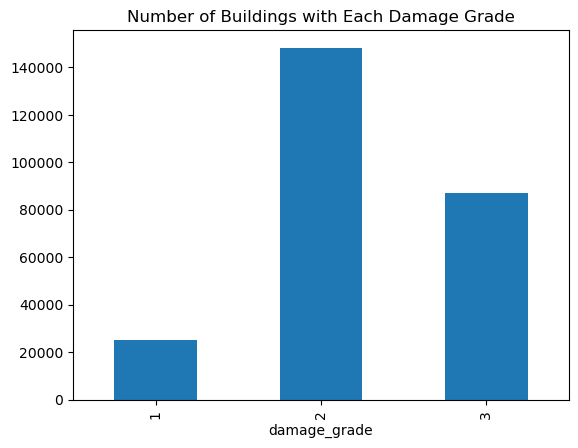

In [76]:
(train_labels.damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of Buildings with Each Damage Grade"))

In [77]:
# select all feature
selected_features = ['foundation_type', 
                     'area_percentage', 
                     'height_percentage',
                     'count_floors_pre_eq',
                     'land_surface_condition',
                     'has_superstructure_cement_mortar_stone']

train_values_subset = train_values[selected_features]

In [78]:
# sns.pairplot(train_values_subset.join(train_labels), 
#              hue='damage_grade')

## Pre-Processing the data

In [79]:
train_values_subset = pd.get_dummies(train_values_subset)

## Building the model - Random Forest

In [80]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

In [81]:
pipe = make_pipeline(StandardScaler(), 
                     RandomForestClassifier(max_features="sqrt", random_state=2018))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=2018))])

In [82]:
param_grid = {'randomforestclassifier__n_estimators': [50, 100],
              'randomforestclassifier__min_samples_leaf': [1, 5]}
gs = GridSearchCV(pipe, param_grid, cv=5)

In [83]:
gs.fit(train_values_subset, train_labels.values.ravel())


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=2018))]),
             param_grid={'randomforestclassifier__min_samples_leaf': [1, 5],
                         'randomforestclassifier__n_estimators': [50, 100]})

In [84]:
gs.best_params_

{'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 100}

In [85]:
from sklearn.metrics import f1_score

in_sample_preds = gs.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average='micro')

0.5893952824432753

## Making predictions

In [86]:
test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')

In [87]:
test_values_subset = test_values[selected_features]
test_values_subset = pd.get_dummies(test_values_subset)

In [88]:
predictions = gs.predict(test_values_subset)

## Save Submissions

In [89]:
submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv', index_col='building_id')

In [90]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [91]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,2
421793,2


In [92]:
my_submission.to_csv('submission.csv')

In [93]:
!head submission.csv

building_id,damage_grade
300051,3
99355,2
890251,2
745817,2
421793,2
871976,2
691228,2
896100,3
343471,2
